# Augmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Dataset 확인

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)
num_classes = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


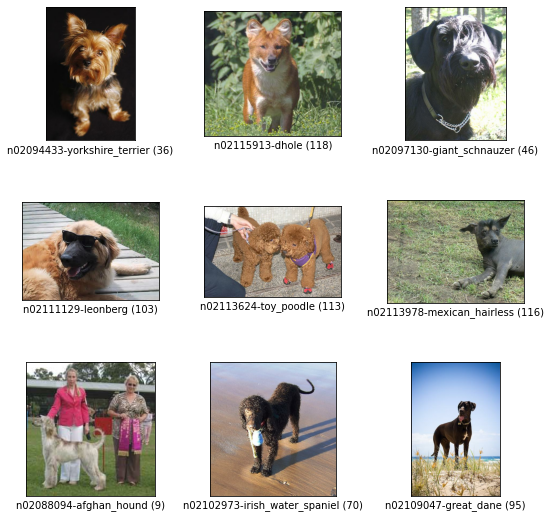

In [3]:
fig = tfds.show_examples(ds_info, ds_train)

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

## 1. Augmentation을 적용한 데이터셋 만들기
### Basic augmentation

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

### CutMix

In [6]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [7]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MixUp

In [10]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [11]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

### data augmentation

In [12]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug: # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [14]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

In [15]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기 / 모델 훈련하기

In [16]:
tf.random.set_seed(2022)

### Basic

In [17]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 203s 208ms/step - loss: 2.2084 - accuracy: 0.4468 - val_loss: 3.2339 - val_accuracy: 0.2225
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.6995 - accuracy: 0.8073 - val_loss: 1.1361 - val_accuracy: 0.6693
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 0.2132 - accuracy: 0.9588 - val_loss: 0.9460 - val_accuracy: 0.7224
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0662 - accuracy: 0.9941 - val_loss: 0.9140 - val_accuracy: 0.7404
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0288 - accuracy: 0.9987 - val_loss: 0.9184 - val_accuracy: 0.7385
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0187 - accuracy: 0.9989 - val_loss: 0.9302 - val_accuracy: 0.7386
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.0146 - accuracy: 0.9990 - val_loss: 0.9451 -

### Basic augmetaion

In [20]:
basic_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
basic_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [22]:
history_basic_aug_resnet50 = basic_aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 212ms/step - loss: 2.2173 - accuracy: 0.4417 - val_loss: 2.8639 - val_accuracy: 0.2937
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.8945 - accuracy: 0.7426 - val_loss: 1.2111 - val_accuracy: 0.6465
Epoch 3/20
750/750 [==============================] - 172s 230ms/step - loss: 0.4426 - accuracy: 0.8832 - val_loss: 1.2456 - val_accuracy: 0.6487
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.2261 - accuracy: 0.9501 - val_loss: 0.9700 - val_accuracy: 0.7219
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 0.1132 - accuracy: 0.9810 - val_loss: 0.9730 - val_accuracy: 0.7262
Epoch 6/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0744 - accuracy: 0.9885 - val_loss: 0.9772 - val_accuracy: 0.7322
Epoch 7/20
750/750 [==============================] - 159s 211ms/step - loss: 0.0405 - accuracy: 0.9957 - val_loss: 0.9840 -

### CutMix

In [23]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [25]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 212ms/step - loss: 3.8067 - accuracy: 0.2174 - val_loss: 3.6046 - val_accuracy: 0.1765
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 2.9340 - accuracy: 0.4340 - val_loss: 1.3088 - val_accuracy: 0.6299
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.5860 - accuracy: 0.5432 - val_loss: 1.3482 - val_accuracy: 0.6301
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 2.3932 - accuracy: 0.6053 - val_loss: 1.2461 - val_accuracy: 0.6500
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 2.2276 - accuracy: 0.6554 - val_loss: 1.4000 - val_accuracy: 0.6267
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 2.1115 - accuracy: 0.7019 - val_loss: 1.3556 - val_accuracy: 0.6325
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 2.0124 - accuracy: 0.7253 - val_loss: 1.1122 -

### MixUp

In [26]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 213ms/step - loss: 3.7167 - accuracy: 0.2480 - val_loss: 4.3590 - val_accuracy: 0.0674
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 2.8602 - accuracy: 0.4843 - val_loss: 1.4566 - val_accuracy: 0.5795
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.5710 - accuracy: 0.5829 - val_loss: 1.4949 - val_accuracy: 0.5908
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 2.3925 - accuracy: 0.6553 - val_loss: 1.2672 - val_accuracy: 0.6491
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 2.2500 - accuracy: 0.7146 - val_loss: 1.3583 - val_accuracy: 0.6240
Epoch 6/20
750/750 [==============================] - 159s 211ms/step - loss: 2.1555 - accuracy: 0.7461 - val_loss: 1.3802 - val_accuracy: 0.6323
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 2.0970 - accuracy: 0.7682 - val_loss: 1.2416 -

## 4. 훈련 과정 시각화하기

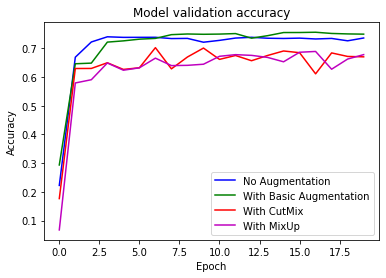

In [29]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='lower right')
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

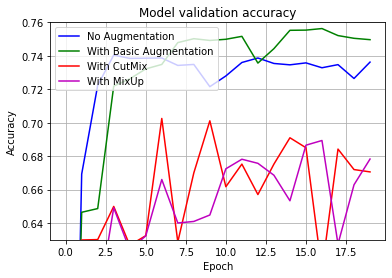

In [30]:
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.plot(history_basic_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'r')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Basic Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.63, 0.76)
plt.show()

## 회고

augmentation을 하지 않은 데이터와, 기본적인 augmetation을 한 데이터를 이용한 모델이 성능이 더 좋게나왔다.  
cutmix, mixup은 성능이 잘 나오지 않아 아쉬웠고, 수정해야하는 부분이 있는 것 같다.